In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import accuracy_score

import os
import re

import torch
import torch.nn as nn
from typing import Union

# Load data

In [2]:
x_test_scaled = pd.read_csv('./data/diabetes/diabetes-clean-test15-normalized.csv')
y_test = x_test_scaled['diabetes']
x_test_scaled = x_test_scaled.drop(['diabetes'], axis=1)

# Load model

In [3]:
class NN(nn.Module):
    """    
    num_features - number of features to learn from
    num_classes: number of classes in output to expect (in this case, 1 or 2, since the output is binary (0 or 1))
    """

    def __init__(self, num_features, num_classes):
        super().__init__() # initialize the init method of nn.Module

        self.num_features = num_features
        self.num_classes = num_classes

        # create a single layer of neurons on which to apply the log reg
        self.linear1 = nn.Linear(num_features, 32)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.output = nn.Linear(16, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        probs = self.linear1(x)
        probs = self.relu1(probs)
        probs = self.linear2(probs)
        probs = self.relu2(probs)
        probs = self.output(probs)
        probs = self.sigmoid(probs)
        return probs
    
    def predict(self, data):
        """
        :param data: torch or list
        :return: np.array with prediction
        """
        
        if not torch.is_tensor(data):
            input = torch.from_numpy(np.array(data)).float()
        else:
            input = torch.squeeze(data).float()
        
        return self.forward(input).detach().numpy()

In [4]:
# Diretório onde estão os arquivos .pt
paht_file = './data/diabetes/NN/models/diabetes_model_acc_tensor(0.7833).pt'

model = NN(num_features=x_test_scaled.shape[1], num_classes=1)
model.load_state_dict(torch.load(paht_file))
print(f"Modelo {paht_file} carregado com sucesso!")

Modelo ./data/diabetes/NN/models/diabetes_model_acc_tensor(0.7833).pt carregado com sucesso!


In [5]:
model

NN(
  (linear1): Linear(in_features=8, out_features=32, bias=True)
  (relu1): ReLU()
  (linear2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=16, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [6]:
model = model
y_test = y_test
X_test = x_test_scaled

# ICE

In [7]:
# Just need ice
from pycebox.ice import ice, ice_plot

In [8]:
# Original Copyright (c) 2015 Austin Rochford and contributors.
# This code is a derivative work of code distributed under the  MIT License (MIT)
# https://github.com/AustinRochford/PyCEbox
       
def my_ice_plot(ice_data, 
                INS_df_list, # Instance of interest
                INS_xy_list, # feature value and prediction for the instance
                frac_to_plot=1.,
                plot_points=False, point_kwargs=None,
                x_quantile=False, 
                centered=False, centered_quantile=0.,
                color_by=None, cmap=None, ax=None, 
                plot_pdp=False,
                plot_ins=False,
                pdp_kwargs=None, 
                INS_df_kwargs=None, 
                INS_xy_kwargs=None,
                **kwargs):

    if not ice_data.index.is_monotonic_increasing:
        ice_data = ice_data.sort_index()

    if centered:
        quantiles = _get_quantiles(ice_data.index)
        centered_quantile_iloc = np.abs(quantiles - centered_quantile).argmin()
        ice_data = ice_data - ice_data.iloc[centered_quantile_iloc]

    if frac_to_plot < 1.:
        n_cols = ice_data.shape[1]
        icols = np.random.choice(n_cols, size=frac_to_plot * n_cols, replace=False)
        plot_ice_data = ice_data.iloc[:, icols]
    else:
        plot_ice_data = ice_data


    if x_quantile:
        x = _get_quantiles(ice_data.index)
    else:
        x = ice_data.index

#     if plot_points:
#         point_x_ilocs = _get_point_x_ilocs(plot_ice_data.index, plot_ice_data.columns)
#         point_x = x[point_x_ilocs]
#         point_y = plot_ice_data.values[point_x_ilocs, np.arange(point_x_ilocs.size)]

    if ax is None:
        _, ax = plt.subplots()


    if color_by is not None:
        if isinstance(color_by, six.string_types):
            colors_raw = plot_ice_data.columns.get_level_values(color_by).values
        elif hasattr(color_by, '__call__'):
            col_df = pd.DataFrame(list(plot_ice_data.columns.values), columns=plot_ice_data.columns.names)
            colors_raw = color_by(col_df)
        else:
            raise ValueError('color_by must be a string or function')

        norm = colors.Normalize(colors_raw.min(), colors_raw.max())
        m = cm.ScalarMappable(norm=norm, cmap=cmap)

        for color_raw, (_, ice_curve) in zip(colors_raw, plot_ice_data.iteritems()):
            c = m.to_rgba(color_raw)
            ax.plot(x, ice_curve, c=c, zorder=0, **kwargs)
    else:
        ax.plot(x, plot_ice_data, zorder=0, **kwargs)

#     if plot_points:
#         ax.scatter(point_x, point_y, zorder=30, **(point_kwargs or {}))

    #plot black line
    if plot_pdp:
        pdp_kwargs = pdp_kwargs or {}
        pdp_data = pdp(ice_data)
        ax.plot(x, pdp_data, **pdp_kwargs)

# Plot Instance
#     if plot_ins:
#         ax.plot(x, INS_df, **INS_df_kwargs)
#         ax.plot(INS_xy[0], INS_xy[1], zorder=10, **INS_xy_kwargs)
#     return ax 
    if plot_ins:
        for i in np.arange(0, len(INS_df_list)):
            INS_df = INS_df_list[i]
            INS_xy = INS_xy_list[i]
            ax.plot(x, INS_df, **INS_df_kwargs)
            ax.plot(INS_xy[0], INS_xy[1], zorder=10, **INS_xy_kwargs)
    
    return ax


def pdp(ice_data):
    Hilight = ice_data.mean(axis=1)
    return Hilight

In [9]:
# Function Definitions

def get_ins(feature_ice_df, odf, Feature, INS):
    instance_df = move_col(odf, Feature)  
    INS_tuple = tuple(instance_df.iloc[INS, :])
    #  print('INS_tuple: ', INS_tuple)
    INS_line = feature_ice_df.loc[:, INS_tuple]
    #  print('INS_line:', INS_line)
    INS_df = pd.DataFrame(INS_line)
    #  print(INS_df)
    return INS_df

def move_col(df, Col):
    df1 = pd.DataFrame(df[Col])
    df2 = df.drop(Col, axis=1)
    df3 = pd.concat([df1, df2], axis=1)
    return df3

def Ins_Feat_Pred(INS, Feat, odf, INS_df):
    FeatN = odf.columns.get_loc(Feat)
    Row_idx = odf.iloc[INS, FeatN]
    idf = move_col(odf, Feat)
    Col_idx = tuple(idf.iloc[INS, :])
    Pred = INS_df.loc[Row_idx, Col_idx]
    return tuple([Row_idx, Pred])

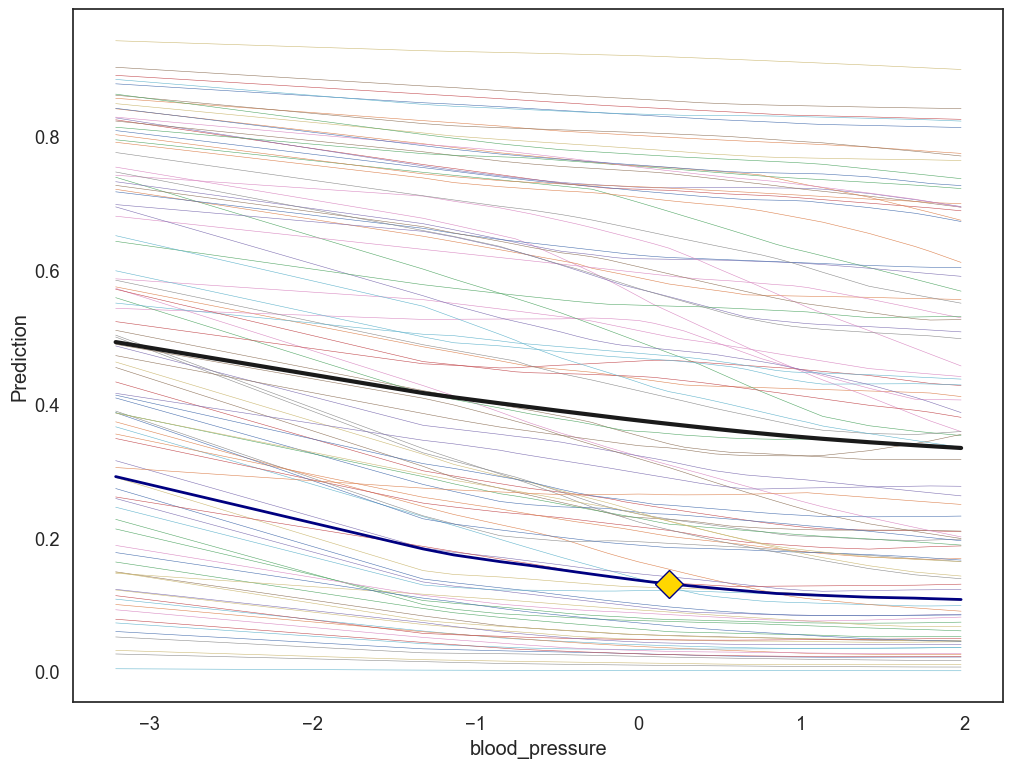

In [10]:
# Using my_ice_plot only

INS = [1]
DATA = X_test
Feature = 'blood_pressure'

sns.set(style="white",  font_scale=1.2, rc={"figure.figsize":(12,9)})

# Using ice function from Pycebox
feature_ice_df = ice(data=DATA, column=Feature, predict=model.predict)

# get Instance df and xy
INS_df_list = []

for instance in INS:
    INS_df = get_ins(feature_ice_df, DATA, Feature, instance)
    INS_df_list.append(INS_df)

#INS_df

INS_xy_list = []
for i in np.arange(0, len(INS)):
    INS_xy = Ins_Feat_Pred(INS[i], Feature, DATA, INS_df_list[i])
    INS_xy_list.append(INS_xy)


# get Instance df and xy
# INS_df = get_ins(feature_ice_df, DATA, Feature, INS)
# INS_xy = Ins_Feat_Pred(INS, Feature, DATA, INS_df)

# Color names: https://matplotlib.org/gallery/color/named_colors.html
my_ice_plot(feature_ice_df, 
            INS_df_list, 
            INS_xy_list,
            linewidth=0.4,
            plot_pdp=True,
            plot_ins=True,
            pdp_kwargs={'c': 'k', 'linewidth': 3},           
            INS_df_kwargs={'c': 'navy', 'linewidth': 2},#, 'marker':'o', 'markersize':8, 'markerfacecolor':'navy'},
            INS_xy_kwargs={'marker':'D', 'markersize':14, 'markerfacecolor':'gold', 'markeredgecolor':'navy'}
            )

plt.ylabel('Prediction')
plt.xlabel(Feature)
plt.show()

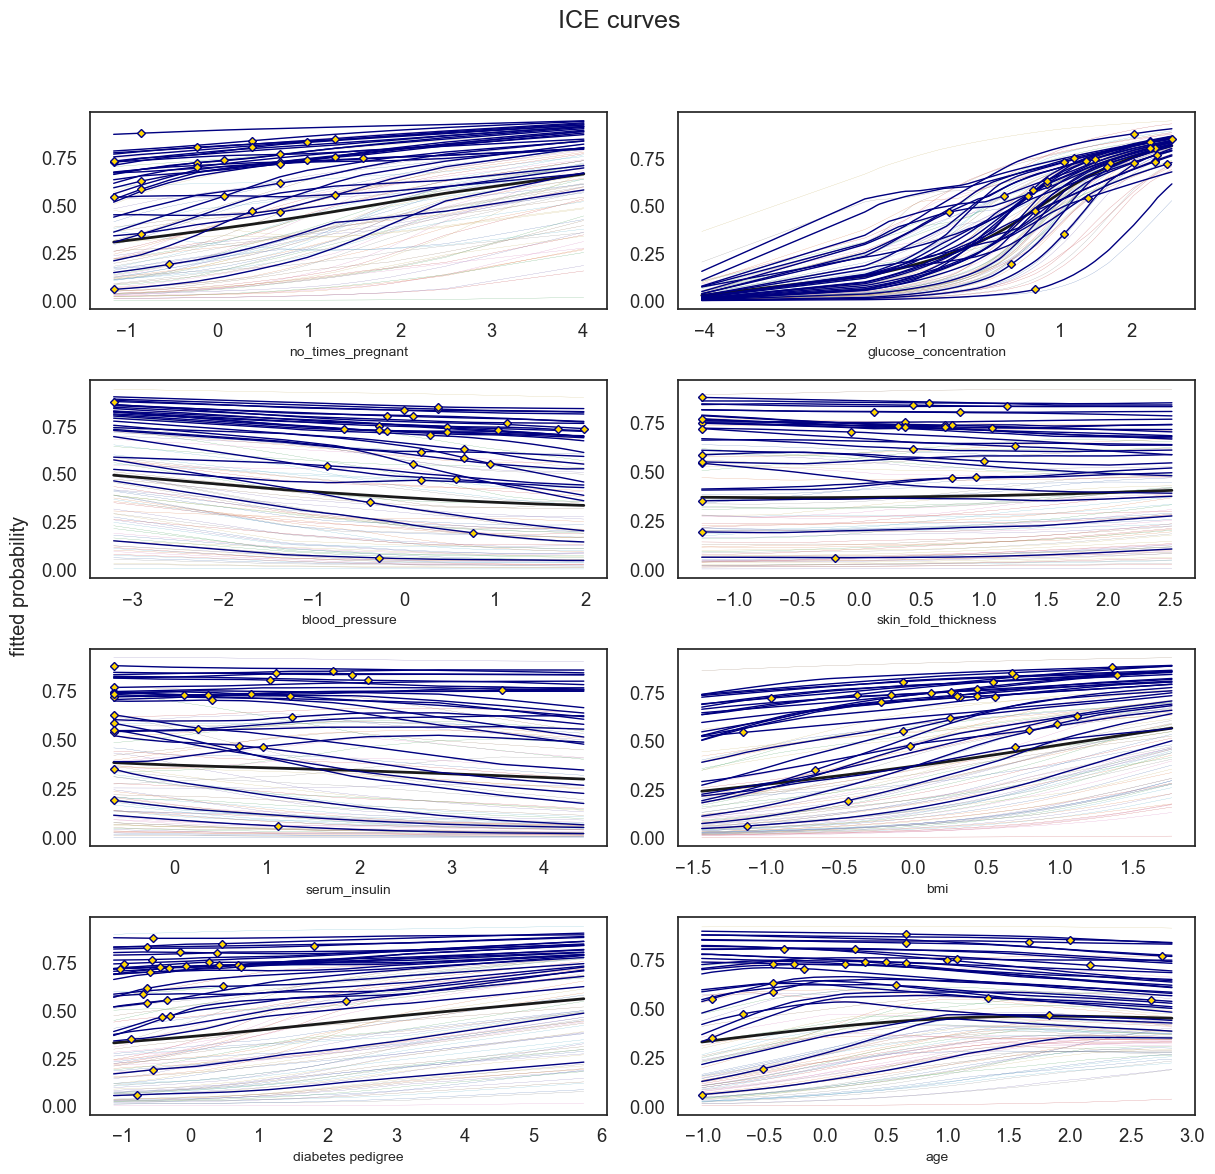

In [12]:
# INS = [ 1,  3, 25, 26, 27, 36, 37, 38, 49, 53, 57, 58, 61, 63, 68, 72, 84, 88, 90]
INS = [ 0,  6,  8, 10, 11, 12, 14, 16, 18, 19, 28, 31, 32, 40, 43, 44, 56, 62, 65, 66, 67, 69, 70, 75, 78, 79, 91, 92]
NumF = X_test.shape[1] 
Row = 4
Col = 2
DATA = X_test

# # Reorder by importance
# ordered_df = X_test.sort_values(by='importance')

# #feature_names = X_test.columns.values
# # Set in Feature Imporatnce
# rdf = ordered_df['feature'].values[::-1]

feature_names = X_test.columns.values.tolist() #rdf[0:NumF]

fig, axes = plt.subplots(Row, Col, figsize=(12, 12))
R=0
C=0

for feature_name in feature_names[:NumF]:

    feature_ice_df = ice(data=DATA, column=feature_name, predict=model.predict)
    
    # get Instance df and xy
    INS_df_list = []

    for instance in INS:
        INS_df = get_ins(feature_ice_df, DATA, feature_name, instance)
        INS_df_list.append(INS_df)

    #INS_df

    INS_xy_list = []
    for i in np.arange(0, len(INS)):
        INS_xy = Ins_Feat_Pred(INS[i], feature_name, DATA, INS_df_list[i])
        INS_xy_list.append(INS_xy)
    
    # get Instance df and xy
#     INS_df = get_ins(feature_ice_df, DATA, feature_name, INS)
#     INS_xy = Ins_Feat_Pred(INS, feature_name, DATA, INS_df)

#     plt.subplot(axes[R, C])
    my_ice_plot(feature_ice_df, 
                INS_df_list, 
                INS_xy_list,
                linewidth=0.15,
                plot_pdp=True,
                plot_ins=True,
                pdp_kwargs={'c': 'k', 'linewidth': 2},           
                INS_df_kwargs={'c': 'navy', 'linewidth': 1},# 'marker':'o', 'markersize':3, 'markerfacecolor':'navy'},
                INS_xy_kwargs={'marker':'D', 'markersize':4, 'markerfacecolor':'gold', 'markeredgecolor':'navy'},
                ax=axes[R, C]
                )
    axes[R, C].set_xlabel(feature_name, fontsize = 10)
    if C == (Col-1): 
        C=0
        R+=1
    else:
        C+=1

fig=axes[0,0].figure
fig.text(0.0,0.5, 'fitted probability', ha="center", va="center", rotation=90)

plt.suptitle('ICE curves', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])